In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs  # 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob
from matplotlib.lines import Line2D

# Moisture uptake Points Function

In [2]:
def Moisture_Trajectory_Analysis(df):
    # Create a range of dates with 6-hour frequency from the minimum to maximum timestamp in 'traj_dt'
    time_range = pd.date_range(start=df['traj_dt'].min(), end=df['traj_dt'].max(), freq='1D') # We !!!!! can be changed as per the user

    # Filter the DataFrame to keep only the rows where 'traj_dt' is in the 6-hour intervals
    df_filtered = df[df['traj_dt'].isin(time_range)]
    # Calculate Moisture Variations (Δq(t)) as the difference in specific humidity
    df_filtered = df_filtered.copy()
    df_filtered['Moisture_Change'] = df_filtered['sp_humidity'].diff(-1).fillna(0)  # First row is set to 0

    # Mark Uptake Points (where Δq(t) > 0.2 g/kg)
    threshold = 0.2  # Moisture change threshold for uptake points
    df_filtered = df_filtered.copy()
    df_filtered['Uptake_Point'] = np.where(df_filtered['Moisture_Change'] > threshold, 1, 0)

    # Mark Loss Points (where Δq(t) < 0)
    df_filtered = df_filtered.copy()
    df_filtered['Loss_Point'] = np.where(df_filtered['Moisture_Change'] < 0, 1, 0)

    # Initialize a list to store previous uptake points and their fractional contributions
    uptake_points = []
    # Change the dataframe to ending point to startyingpoint where satrt is the target region
    df_filtered=df_filtered[::-1]

    # Initialize variables
    df_filtered=df_filtered.copy()
    # Initialize Fractional Contribution and Moisture Loss Variables
    df_filtered['Fractional_Contribution'] = 0.0
    df_filtered['Moisture_Loss']=0.0
    # To track the last Uptake_Point index
    last_uptake_idx = []  
    for idx,row in df_filtered.iterrows():
        # if its first the uptake point, then evaluate the fractional Contribution for that point dq(m)/q(m)
        if(row['Uptake_Point']==1):
            dq=row['Moisture_Change']
            q= row['sp_humidity']
            f_t = dq/q
            df_filtered.at[idx, 'Fractional_Contribution'] = f_t
            
            # Moisture Loss is assumed to be zero 
            df_filtered.at[idx,'Moisture_Loss']=0
        
            # Update the previous uptake points such that Fractional Contribution is dq(n)/q(m) where n is the previous uptake point
            for prev_idx in last_uptake_idx:
                dq=row['Moisture_Change']
                prev_dq=df_filtered.loc[prev_idx, 'Moisture_Change']
                df_filtered.at[prev_idx,'Fractional_Contribution']=prev_dq/q
                
                # Moisture Loss is assumed to be zero 
                df_filtered.at[prev_idx,'Moisture_Loss']=0
            last_uptake_idx.append(idx)
    
    # if its the loss point, then, update the previous uptake points (no affect on the fractional distribution)
        elif(row['Loss_Point']==1):
            dq=row['Moisture_Change']
            q= row['sp_humidity']
            #df_filtered.at[idx,'Moisture_Loss']=dq * row['Fractional_Contribution']
            # Loss Point: Update moisture changes for previous uptake points
            for prev_idx in last_uptake_idx:
                prev_dq = df_filtered.loc[prev_idx, 'Moisture_Change']
                prev_f = df_filtered.loc[prev_idx, 'Fractional_Contribution']
                
                # The moisture change will become dq(n)=dq(n)+dq(m)*fractional_contribution(n)
                df_filtered.at[prev_idx, 'Moisture_Change'] = prev_dq + dq * prev_f
                df_filtered.at[prev_idx,'Moisture_Loss']=prev_dq * prev_f

    # Evaluation of Moisture Attribution as the released moisture over the target region            
    attributed_moisture=-df_filtered.iloc[-1]['Moisture_Change']
    df_filtered['Attributed_Moisture']=df_filtered['Fractional_Contribution']*attributed_moisture
    return df_filtered

# Moisture Uptake and Release at a Pressure Level

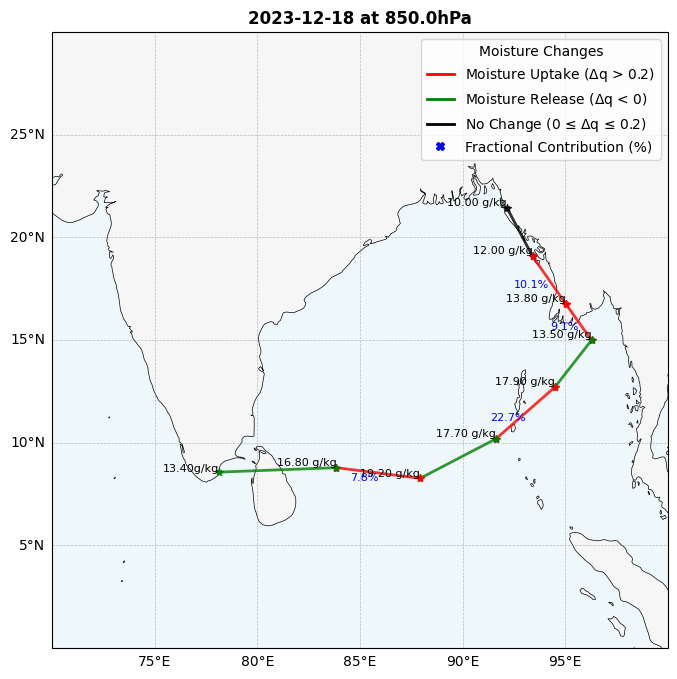

In [ ]:
# Update this with your actual CSV file path
csv_file_path="C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/data/hysplit/Kayalpattinam_2023-12-18.csv"
df = pd.read_csv(csv_file_path,index_col=0)

# Ensure pressure levels are correctly interpreted
df['pressure_level'] = df['height_m'].apply(
    lambda h: round(1013.25 * (1 - h / (145366.45 * 0.3048))**(1 / 0.190284), 0)
)
# Ensure 'traj_dt_i' is in datetime format, if only date is present, set time to 00:00:00
# Convert to datetime, handling both dates and full timestamps
df['traj_dt_i'] = pd.to_datetime(df['traj_dt_i'],format='mixed')
df['traj_dt'] = pd.to_datetime(df['traj_dt'],format='mixed')

pressure=850.0 #,850.0,500.0:

df1=[df[(df['pressure_level']==pressure) & (df['traj_dt_i']==f'2023-12-18 {value}:00:00')] for value in ['12']]
df_moisture=[Moisture_Trajectory_Analysis(df) for df in df1] 

# Initialize the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features to the map
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.2)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

# Set plot extent (min/max lat/lon)
min_lon, max_lon = 70, 100   # Example longitude range
min_lat, max_lat = 0, 30    # Example latitude range
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot trajectory with color-coded segments and annotations
threshold = 0.2  # Moisture change threshold

for df in df_moisture:
    for i in range(len(df) - 1):
        start_lon, start_lat = df.iloc[i]['lon'], df.iloc[i]['lat']
        end_lon, end_lat = df.iloc[i + 1]['lon'], df.iloc[i + 1]['lat']
        moisture_change = df.iloc[i]['Moisture_Change']
        sp_humidity = df.iloc[i]['sp_humidity']  # Extract specific humidity

        # Determine line color
        if moisture_change > threshold:
            color = 'red'
        elif moisture_change < 0:
            color = 'green'
        else:
            color = 'black'

        # Plot the line segment
        ax.plot(
            [start_lon, end_lon],
            [start_lat, end_lat],
            color=color, marker='*',
            transform=ccrs.PlateCarree(),
            linewidth=2,
            alpha=0.8
        )
        # Plot the annotation
        annotation_text = f"{sp_humidity:.2f} g/kg"
        ax.text(
            start_lon, start_lat,
            annotation_text,  # Annotation content
            transform=ccrs.PlateCarree(),
            fontsize=8,
            color='black',  # Dynamic text color
            ha='right', va='bottom'
        )        
        # Calculate the midpoint for annotation
        mid_lon = (start_lon + end_lon) / 2
        mid_lat = (start_lat + end_lat) / 2

        # Add annotations based on moisture change type
        if moisture_change > threshold and 'Fractional_Contribution' in df.columns:
            fractional_contribution = df.iloc[i]['Fractional_Contribution'] * 100
            ax.text(
                mid_lon, mid_lat,
                f"{fractional_contribution.round(1)}%",  # Format to 1 decimal place
                transform=ccrs.PlateCarree(),
                fontsize=8,
                color='blue',  # Text color for positive changes
                ha='right', va='top'
            )
    ax.text(
        df.iloc[-1]['lon'], df.iloc[-1]['lat'],
        f"{df.iloc[-1]['sp_humidity']:.2f}g/kg",  # Annotation content
        transform=ccrs.PlateCarree(),
        fontsize=8,
        color='black',  # Dynamic text color
        ha='right', va='baseline'
    )   
# Create custom legend
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Moisture Uptake ($\Delta$q > 0.2)'),
    Line2D([0], [0], color='green', lw=2, label='Moisture Release ($\Delta$q < 0)'),
    Line2D([0], [0], color='black', lw=2, label='No Change (0 ≤ $\Delta$q ≤ 0.2)'),
    Line2D([0], [0], color='blue', marker='X', lw=0, label='Fractional Contribution (%)'),]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10, title='Moisture Changes')

# Add title
plt.title(f'2023-12-18 at {pressure}hPa', fontsize=12, weight='bold')

# Show the plot
plt.savefig(f"C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/Figures/Moisture_Uptake_{pressure}hPa.png",dpi=300,bbox_inches='tight')


# Moisture Uptake and Release For All Pressure levels ast single plot

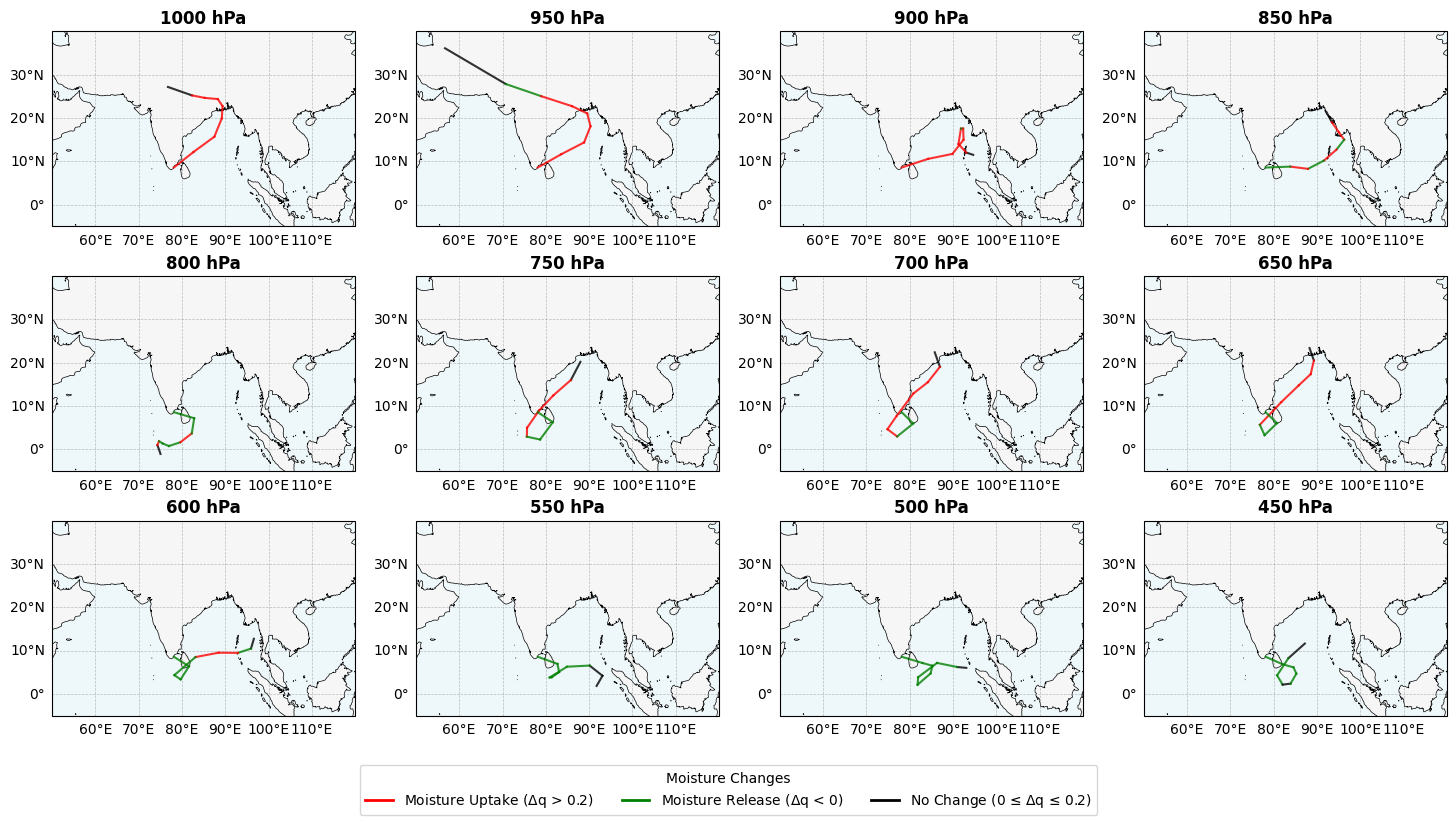

In [15]:
# Update this with your actual CSV file path
csv_file_path="hysplit\Kayalpattinam_2023-12-18.csv"
df = pd.read_csv(csv_file_path,index_col=0)

# Ensure pressure levels are correctly interpreted
df['pressure_level'] = df['height_m'].apply(
    lambda h: round(1013.25 * (1 - h / (145366.45 * 0.3048))**(1 / 0.190284), 0)
)
# Ensure 'traj_dt_i' is in datetime format, if only date is present, set time to 00:00:00
# Convert to datetime, handling both dates and full timestamps
df['traj_dt_i'] = pd.to_datetime(df['traj_dt_i'],format='mixed')
df['traj_dt'] = pd.to_datetime(df['traj_dt'],format='mixed')
pressure_levels=df['pressure_level'].unique()
pressure_levels=pressure_levels[:-1]
# Create a 3x4 grid for subplots
fig, axes = plt.subplots(3, 4, figsize=(18, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through pressure levels and plot on respective subplot
for idx, level in enumerate(pressure_levels):
    ax = axes[idx]

    # Filter data for the current pressure level at specified time intervals
    df1 = [
        df[(df['pressure_level'] == level) & (df['traj_dt_i'] == f'2023-12-18 {value}:00:00')]
        for value in ['12'] # for only one value ['00','06','12','18'] otherwise
    ]
    df_moisture = [Moisture_Trajectory_Analysis(sub_df) for sub_df in df1]

    # Add features to the map
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.2)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

    # Set plot extent (min/max lat/lon)
    min_lon, max_lon = 50, 120   #  longitude range
    min_lat, max_lat = -5, 40    #latitude range
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Add gridlines with labels for latitude and longitude
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable labels at the top
    gl.right_labels = False  # Disable labels on the right

    # Plot trajectory with color-coded segments
    threshold = 0.2  # Moisture change threshold
    for df_traj in df_moisture:
        for i in range(len(df_traj) - 1):
            start_lon, start_lat = df_traj.iloc[i]['lon'], df_traj.iloc[i]['lat']
            end_lon, end_lat = df_traj.iloc[i + 1]['lon'], df_traj.iloc[i + 1]['lat']
            moisture_change = df_traj.iloc[i]['Moisture_Change']

            # Determine line color
            if moisture_change > threshold:
                color = 'red'  # Uptake
            elif moisture_change < 0:
                color = 'green'  # Release
            else:
                color = 'black'  # No change

            # Plot the line segment
            ax.plot(
                [start_lon, end_lon],
                [start_lat, end_lat],
                color=color,
                transform=ccrs.PlateCarree(),
                linewidth=1.5,
                alpha=0.8
            )
            ax.set_title(f'{int(level)} hPa',weight='bold')
# Create custom legend
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Moisture Uptake ($\Delta$q > 0.2)'),
    Line2D([0], [0], color='green', lw=2, label='Moisture Release ($\Delta$q < 0)'),
    Line2D([0], [0], color='black', lw=2, label='No Change (0 ≤ $\Delta$q ≤ 0.2)')]

fig.legend(handles=legend_elements, loc='lower center', fontsize=10, title='Moisture Changes', ncol=4)
# Add main title#
#fig.suptitle('Moisture Uptake and Release Trajectories for 2023-12-18 12:00:00')

# Show the plot
plt.savefig("C://Users/sreega/Desktop/Workstation/EPE_Kayalpattinam/Figures/Moisture_Trajectories.png",dpi=500,bbox_inches='tight')


# Averaged Moisture Pathways Like Nayak for 1 starting from all for starting points


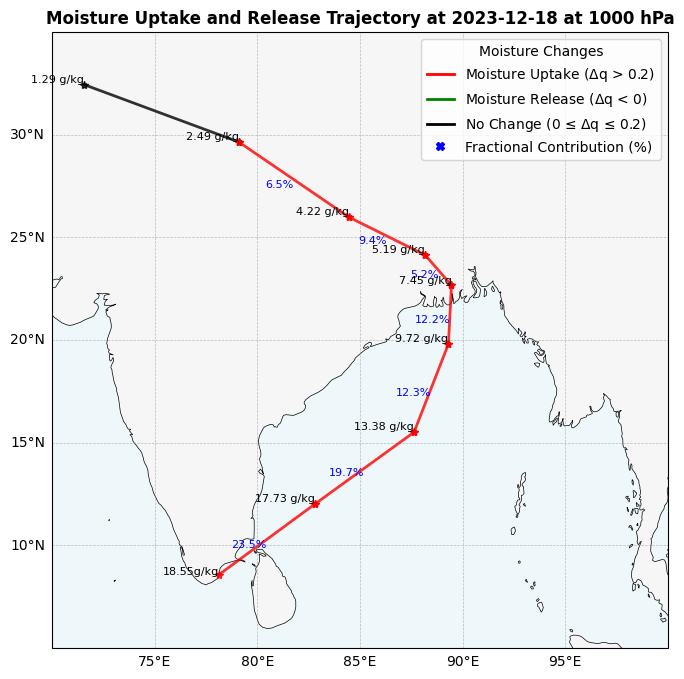

In [147]:
# Update this with your actual CSV file path
csv_file_path="hysplit\Kayalpattinam_2023-12-18.csv"
df = pd.read_csv(csv_file_path,index_col=0)

# Ensure pressure levels are correctly interpreted
df['pressure_level'] = df['height_m'].apply(
    lambda h: round(1013.25 * (1 - h / (145366.45 * 0.3048))**(1 / 0.190284), 0)
)
# Ensure 'traj_dt_i' is in datetime format, if only date is present, set time to 00:00:00
# Convert to datetime, handling both dates and full timestamps
df['traj_dt_i'] = pd.to_datetime(df['traj_dt_i'],format='mixed')
df['traj_dt'] = pd.to_datetime(df['traj_dt'],format='mixed')
grouped_df=df.groupby(['hour_along','pressure_level']).agg(
            {'lat':'mean',
            'lon':'mean',
            'sp_humidity':'mean',
            'traj_dt':'first',
            'lat_i':'first',
            'lon_i':'first',
            }).reset_index()

df1=grouped_df[(grouped_df['pressure_level']==1000.0)].sort_values(by='hour_along',ascending=False)

df_moisture=Moisture_Trajectory_Analysis(df1) 

# Initialize the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features to the map
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.2)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

# Set plot extent (min/max lat/lon)
min_lon, max_lon = 70, 100   # Example longitude range
min_lat, max_lat = 5, 35    # Example latitude range
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot trajectory with color-coded segments and annotations
threshold = 0.2  # Moisture change threshold


for i in range(len(df_moisture) - 1):
    start_lon, start_lat = df_moisture.iloc[i]['lon'], df_moisture.iloc[i]['lat']
    end_lon, end_lat = df_moisture.iloc[i + 1]['lon'], df_moisture.iloc[i + 1]['lat']
    moisture_change = df_moisture.iloc[i]['Moisture_Change']
    sp_humidity = df_moisture.iloc[i]['sp_humidity']  # Extract specific humidity

    # Determine line color
    if moisture_change > threshold:
        color = 'red'
    elif moisture_change < 0:
        color = 'green'
    else:
        color = 'black'

    # Plot the line segment
    ax.plot(
        [start_lon, end_lon],
        [start_lat, end_lat],
        color=color, marker='*',
        transform=ccrs.PlateCarree(),
        linewidth=2,
        alpha=0.8
    )
    # Plot the annotation
    annotation_text = f"{sp_humidity:.2f} g/kg"
    ax.text(
        start_lon, start_lat,
        annotation_text,  # Annotation content
        transform=ccrs.PlateCarree(),
        fontsize=8,
        color='black',  # Dynamic text color
        ha='right', va='bottom'
    )        
    # Calculate the midpoint for annotation
    mid_lon = (start_lon + end_lon) / 2
    mid_lat = (start_lat + end_lat) / 2

    # Add annotations based on moisture change type
    if moisture_change > threshold and 'Fractional_Contribution' in df_moisture.columns:
        fractional_contribution = df_moisture.iloc[i]['Fractional_Contribution'] * 100
        ax.text(
            mid_lon, mid_lat,
            f"{fractional_contribution.round(1)}%",  # Format to 1 decimal place
            transform=ccrs.PlateCarree(),
            fontsize=8,
            color='blue',  # Text color for positive changes
            ha='right', va='top'
        )
ax.text(
    df_moisture.iloc[-1]['lon'], df_moisture.iloc[-1]['lat'],
    f"{df_moisture.iloc[-1]['sp_humidity']:.2f}g/kg",  # Annotation content
    transform=ccrs.PlateCarree(),
    fontsize=8,
    color='black',  # Dynamic text color
    ha='right', va='baseline'
)   
# Create custom legend
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Moisture Uptake ($\Delta$q > 0.2)'),
    Line2D([0], [0], color='green', lw=2, label='Moisture Release ($\Delta$q < 0)'),
    Line2D([0], [0], color='black', lw=2, label='No Change (0 ≤ $\Delta$q ≤ 0.2)'),
    Line2D([0], [0], color='blue', marker='X', lw=0, label='Fractional Contribution (%)'),]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10, title='Moisture Changes')

# Add title
plt.title('Moisture Uptake and Release Trajectory at 2023-12-18 at 1000 hPa', fontsize=12, weight='bold')

# Show the plot
plt.show()



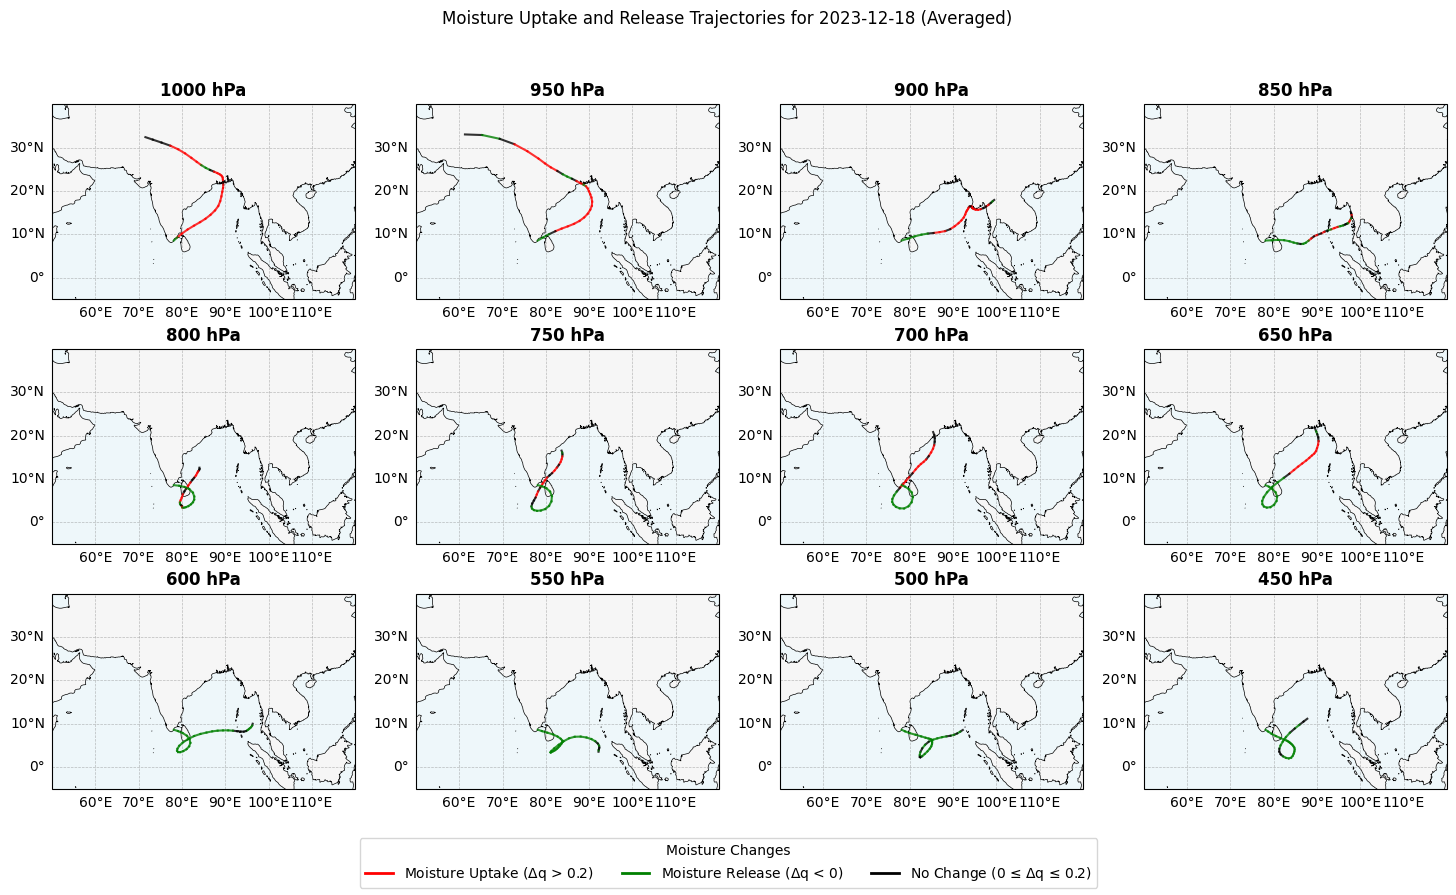

In [181]:
# Update this with your actual CSV file path
csv_file_path="hysplit\Kayalpattinam_2023-12-18.csv"
df = pd.read_csv(csv_file_path,index_col=0)

# Ensure pressure levels are correctly interpreted
df['pressure_level'] = df['height_m'].apply(
    lambda h: round(1013.25 * (1 - h / (145366.45 * 0.3048))**(1 / 0.190284), 0)
)
# Ensure 'traj_dt_i' is in datetime format, if only date is present, set time to 00:00:00
# Convert to datetime, handling both dates and full timestamps
df['traj_dt_i'] = pd.to_datetime(df['traj_dt_i'],format='mixed')
df['traj_dt'] = pd.to_datetime(df['traj_dt'],format='mixed')
grouped_df=df.groupby(['hour_along','pressure_level']).agg(
            {'lat':'mean',
            'lon':'mean',
            'sp_humidity':'mean',
            'traj_dt':'first',
            'lat_i':'first',
            'lon_i':'first',
            }).reset_index()

df1=grouped_df.sort_values(by='hour_along',ascending=False)
pressure_levels=df1['pressure_level'].unique()
pressure_levels=np.sort(np.array(pressure_levels))[::-1][:-1]

# Create a 3x4 grid for subplots
fig, axes = plt.subplots(3, 4, figsize=(18, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through pressure levels and plot on respective subplot
for idx, level in enumerate(pressure_levels):
    ax = axes[idx]

    # Filter data for the current pressure level at specified time intervals
    df2 = [
        df1[(df1['pressure_level'] == level)]
        for value in ['12'] # for only one value ['00','06','12','18'] otherwise
    ]
    df_moisture = [Moisture_Trajectory_Analysis(sub_df) for sub_df in df2]

    # Add features to the map
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.2)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

    # Set plot extent (min/max lat/lon)
    min_lon, max_lon = 50, 120   #  longitude range
    min_lat, max_lat = -5, 40    #latitude range
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Add gridlines with labels for latitude and longitude
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable labels at the top
    gl.right_labels = False  # Disable labels on the right

    # Plot trajectory with color-coded segments
    threshold = 0.2  # Moisture change threshold
    for df_traj in df_moisture:
        for i in range(len(df_traj) - 1):
            start_lon, start_lat = df_traj.iloc[i]['lon'], df_traj.iloc[i]['lat']
            end_lon, end_lat = df_traj.iloc[i + 1]['lon'], df_traj.iloc[i + 1]['lat']
            moisture_change = df_traj.iloc[i]['Moisture_Change']

            # Determine line color
            if moisture_change > threshold:
                color = 'red'  # Uptake
            elif moisture_change < 0:
                color = 'green'  # Release
            else:
                color = 'black'  # No change

            # Plot the line segment
            ax.plot(
                [start_lon, end_lon],
                [start_lat, end_lat],
                color=color,
                transform=ccrs.PlateCarree(),
                linewidth=1.5,
                alpha=0.8
            )
            ax.set_title(f'{int(level)} hPa',weight='bold')
# Create custom legend
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Moisture Uptake ($\Delta$q > 0.2)'),
    Line2D([0], [0], color='green', lw=2, label='Moisture Release ($\Delta$q < 0)'),
    Line2D([0], [0], color='black', lw=2, label='No Change (0 ≤ $\Delta$q ≤ 0.2)')]

fig.legend(handles=legend_elements, loc='lower center', fontsize=10, title='Moisture Changes', ncol=4)
# Add main title#
fig.suptitle('Moisture Uptake and Release Trajectories for 2023-12-18 (Averaged)')

# Show the plot
plt.show()
